# 1: Import các thư viện

In [ ]:
import pandas as pd # Đọc dữ liệu
import numpy as np # Xử lý dữ liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import EarlyStopping, ModelCheckpoint # Lưu lại mô hình huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo % sai số tuyệt đối trung bình

# 2: Đọc dữ liệu

In [ ]:
# Cấp quyền truy cập google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/MSN.csv')

# Drop dòng "Open Interest" không dùng đến trong dataset
df = df.drop(columns=["Open Interest"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

       Ticker         Date/Time  Open  High   Low  Close  Volume
0         MSN   12/25/2017 9:15  73.1  73.1  73.1   73.1    4210
1         MSN   12/25/2017 9:16  73.0  73.0  73.0   73.0    5000
2         MSN   12/25/2017 9:18  73.5  73.5  73.5   73.5     210
3         MSN   12/25/2017 9:20  73.2  73.5  73.1   73.1    2050
4         MSN   12/25/2017 9:21  73.0  73.0  73.0   73.0    1380
...       ...               ...   ...   ...   ...    ...     ...
135349    MSN  12/22/2020 14:23  82.8  82.8  82.8   82.8     700
135350    MSN  12/22/2020 14:24  82.7  82.8  82.7   82.8    4660
135351    MSN  12/22/2020 14:25  82.8  82.8  82.8   82.8      50
135352    MSN  12/22/2020 14:27  82.8  82.8  82.8   82.8     300
135353    MSN  12/22/2020 14:46  82.8  82.8  82.8   82.8     200

[135354 rows x 7 columns]


# 3: Mô tả dữ liệu

In [ ]:
# Định dạng cấu trúc thời gian
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

In [ ]:
# Kích thước dữ liệu
df.shape

(135354, 7)

In [ ]:
# Dữ liệu 5 dòng đầu
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,MSN,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210
1,MSN,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000
2,MSN,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210
3,MSN,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050
4,MSN,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380


In [ ]:
# Xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     135354 non-null  object        
 1   Date/Time  135354 non-null  datetime64[ns]
 2   Open       135354 non-null  float64       
 3   High       135354 non-null  float64       
 4   Low        135354 non-null  float64       
 5   Close      135354 non-null  float64       
 6   Volume     135354 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 7.2+ MB


In [ ]:
# Mô tả bộ dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,135354,135354.000000,135354.000000,135354.000000,135354.000000,1.353540e+05
mean,2019-07-30 01:41:35.644310528,74.878809,74.931668,74.834625,74.880759,5.683578e+03
min,2017-12-25 09:15:00,46.500000,46.500000,46.400000,46.400000,1.000000e+01
25%,2018-10-16 13:15:15,57.900000,57.900000,57.800000,57.800000,5.000000e+02
50%,2019-08-26 10:44:30,79.100000,79.200000,79.100000,79.100000,2.000000e+03
75%,2020-05-12 13:20:45,86.000000,86.100000,86.000000,86.000000,5.560000e+03
max,2020-12-22 14:46:00,117.800000,118.000000,117.700000,118.000000,3.300680e+06
std,NaN,15.418074,15.426954,15.412677,15.418857,2.798513e+04


# 4: Tiền xử lý dữ liệu

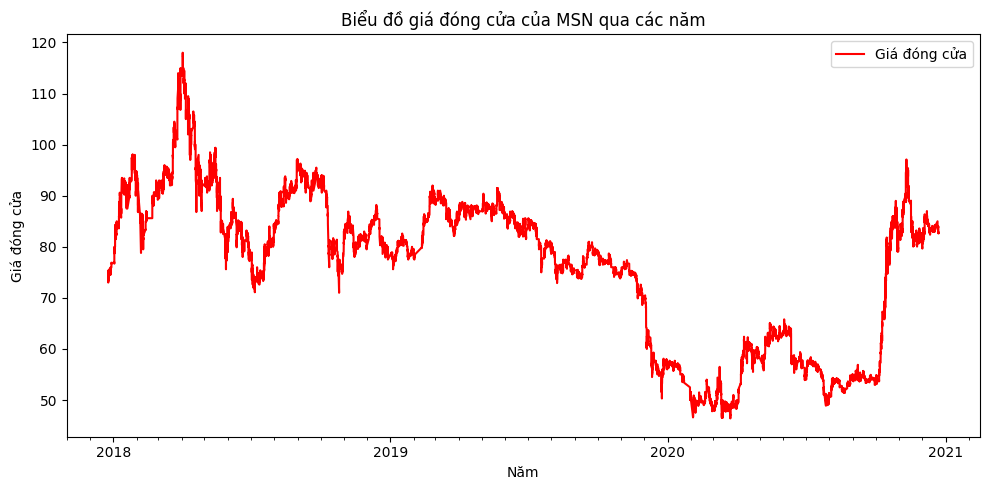

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi
# Chuyển đổi cột "Date/Time" sang dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Date/Time')

# Chuyển đổi định dạng các cột giá thành số thực
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

# Lấy thông tin năm từ cột "Date/Time"
df['Year'] = df['Date/Time'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của MSN qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout() # Loại bỏ các giá trị trùng lặp
plt.show()

In [ ]:
df1 = pd.DataFrame(df,columns=['Date/Time','Close'])
df1.index = df1['Date/Time']
df1.drop('Date/Time', axis=1, inplace=True)
df1

,Close
Date/Time,
2017-12-25 09:15:00,73.1
2017-12-25 09:16:00,73.0
2017-12-25 09:18:00,73.5
2017-12-25 09:20:00,73.1
2017-12-25 09:21:00,73.0
...,...
2020-12-22 14:23:00,82.8
2020-12-22 14:24:00,82.8
2020-12-22 14:25:00,82.8


In [ ]:
# Chia tập dữ liệu: 80% để huấn luyện mô hình và 20% dùng để test
data = df1.values
num_rows = len(data)
train_size = int(0.8 * num_rows)

train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
data

array([[73.1],
       [73. ],
       [73.5],
       ...,
       [82.8],
       [82.8],
       [82.8]])

In [ ]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [ ]:
# Tạo vòng lặp các giá trị
x_train, y_train=[], []
for i in range(60, len(train_data)):
  x_train.append(sc_train[i-60:i, 0]) #lấy 60 giá đóng cửa liên tục
  y_train.append(sc_train[i, 0]) #lấy ra giá đóng cửa ngày hôm sau

In [ ]:
x_train

[array([0.37290503, 0.37150838, 0.37849162, 0.37290503, 0.37150838,
        0.37290503, 0.37290503, 0.37569832, 0.37849162, 0.37569832,
        0.37290503, 0.37290503, 0.37290503, 0.37569832, 0.37569832,
        0.37569832, 0.37430168, 0.37569832, 0.37569832, 0.37430168,
        0.37290503, 0.37430168, 0.37290503, 0.37150838, 0.37150838,
        0.37150838, 0.37150838, 0.37290503, 0.37150838, 0.37150838,
        0.37290503, 0.37290503, 0.37290503, 0.37430168, 0.37569832,
        0.37569832, 0.37849162, 0.38268156, 0.38268156, 0.38547486,
        0.38547486, 0.38547486, 0.38547486, 0.38826816, 0.38547486,
        0.38547486, 0.38547486, 0.38547486, 0.38547486, 0.38826816,
        0.38687151, 0.38687151, 0.38687151, 0.38687151, 0.38547486,
        0.38407821, 0.38407821, 0.38268156, 0.38128492, 0.38128492]),
 array([0.37150838, 0.37849162, 0.37290503, 0.37150838, 0.37290503,
        0.37290503, 0.37569832, 0.37849162, 0.37569832, 0.37290503,
        0.37290503, 0.37290503, 0.37569832, 0.

In [ ]:
y_train

[0.3840782122905029,
 0.3812849162011174,
 0.3812849162011174,
 0.3784916201117319,
 0.3784916201117319,
 0.37709497206703935,
 0.3756983240223464,
 0.37709497206703935,
 0.3756983240223464,
 0.37709497206703935,
 0.37709497206703935,
 0.37709497206703935,
 0.37709497206703935,
 0.37709497206703935,
 0.3854748603351956,
 0.37709497206703935,
 0.3784916201117319,
 0.3784916201117319,
 0.3784916201117319,
 0.3854748603351956,
 0.3784916201117319,
 0.3854748603351956,
 0.3840782122905029,
 0.3812849162011174,
 0.3826815642458101,
 0.3840782122905029,
 0.3854748603351956,
 0.3854748603351956,
 0.3854748603351956,
 0.3868715083798884,
 0.3882681564245811,
 0.3882681564245811,
 0.3882681564245811,
 0.3882681564245811,
 0.3882681564245811,
 0.3896648044692739,
 0.3896648044692739,
 0.3910614525139666,
 0.3924581005586594,
 0.3924581005586594,
 0.3994413407821229,
 0.3994413407821229,
 0.3994413407821229,
 0.4022346368715084,
 0.3924581005586594,
 0.4050279329608941,
 0.4022346368715084,
 0.39

In [ ]:
# Xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

# Xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# 5: Xây dựng và huấn luyện mô hình

## 5.1: Xây dựng

In [ ]:
# Xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào

# 2 lớp LSTM
model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
# Đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error', optimizer='adam')

## 5.2: Huấn luyện

In [ ]:
# Huấn luyện mô hình
save_model = "/content/drive/MyDrive/dataset/MSN_save_model.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='loss', patience=10) # Ngừng huấn luyện nếu như mô hình không còn cải thiện sau 10 epochs
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[best_model, early_stopping])

Epoch 1/100

Epoch 1: loss improved from inf to 0.01776, saving model to /content/drive/MyDrive/dataset/MSN_save_model.keras
1691/1691 - 299s - loss: 0.0178 - 299s/epoch - 177ms/step
Epoch 2/100

Epoch 2: loss improved from 0.01776 to 0.01757, saving model to /content/drive/MyDrive/dataset/MSN_save_model.keras
1691/1691 - 308s - loss: 0.0176 - 308s/epoch - 182ms/step
Epoch 3/100

Epoch 3: loss improved from 0.01757 to 0.01740, saving model to /content/drive/MyDrive/dataset/MSN_save_model.keras
1691/1691 - 297s - loss: 0.0174 - 297s/epoch - 176ms/step
Epoch 4/100

Epoch 4: loss improved from 0.01740 to 0.01728, saving model to /content/drive/MyDrive/dataset/MSN_save_model.keras
1691/1691 - 296s - loss: 0.0173 - 296s/epoch - 175ms/step
Epoch 5/100

Epoch 5: loss improved from 0.01728 to 0.01720, saving model to /content/drive/MyDrive/dataset/MSN_save_model.keras
1691/1691 - 298s - loss: 0.0172 - 298s/epoch - 176ms/step
Epoch 6/100

Epoch 6: loss did not improve from 0.01720
1691/1691 - 3

In [ ]:
# Dữ liệu train
y_train = sc.inverse_transform(y_train) # Giá thực
final_model = load_model("/content/drive/MyDrive/dataset/MSN_save_model.keras")
y_train_predict = final_model.predict(x_train) # Dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) # Giá dự đoán

3382/3382 [==============================] - 141s 41ms/step


# 6: Sử dụng mô hình

In [ ]:
# Xử lý dữ liệu test
test = df1[len(train_data)-60:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(60, test.shape[0]):
  x_test.append(sc_test[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Dữ liệu test
y_test = data[train_size:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) # Giá dự đoán

846/846 [==============================] - 35s 41ms/step


# Độ chính xác của mô hình

<ipython-input-33-df492ed38fce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict # Thêm dữ liệu
<ipython-input-33-df492ed38fce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict # Thêm dữ liệu


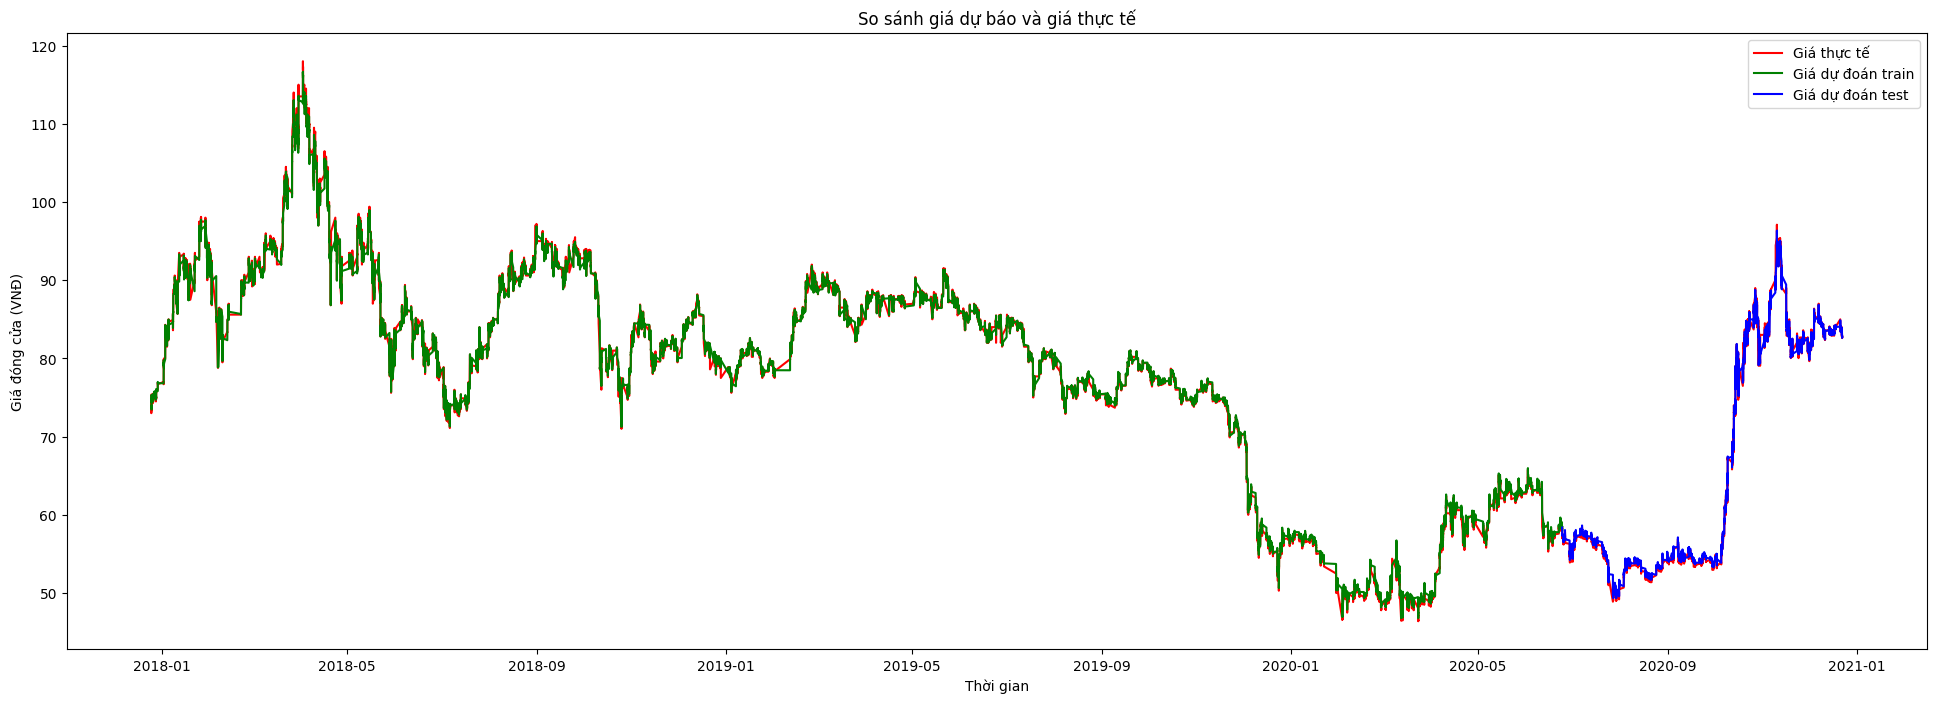

In [ ]:
# Lập biểu đồ so sánh
train_data1 = df1[60:train_size]
test_data1 = df1[train_size:]

plt.figure(figsize=(24, 8))
plt.plot(df1,label='Giá thực tế', color='red') # Đường giá thực
train_data1['Dự đoán'] = y_train_predict # Thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green') # Đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict # Thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue') # Đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') # Đặt tên biểu đồ
plt.xlabel('Thời gian') # Đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') # Đặt tên hàm y
plt.legend() # Chú thích
plt.show()

In [ ]:
# r2
print('Độ phù hợp tập train:', r2_score(y_train, y_train_predict))

# mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# mae
print('Phần trăm sai số tuyệt đối trung bình tập train:', mean_absolute_percentage_error(y_train, y_train_predict))

Độ phù hợp tập train: 0.9996189108105292
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.2084124169451408
Phần trăm sai số tuyệt đối trung bình tập train: 0.0029210837379545313


In [ ]:
train_data1

,Close,Dự đoán
Date/Time,,
2017-12-25 11:11:00,73.9,73.850761
2017-12-25 11:19:00,73.7,73.993462
2017-12-25 11:21:00,73.7,73.879547
2017-12-25 11:28:00,73.5,73.852036
2017-12-25 11:29:00,73.5,73.695641
...,...,...
2020-06-24 13:44:00,58.0,58.379128
2020-06-24 13:45:00,58.1,58.298264
2020-06-24 13:46:00,58.0,58.365131


In [ ]:
# r2
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict))

# mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# mae
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict))

Độ phù hợp tập test: 0.9994103107786366
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.27725716613181095
Phần trăm sai số tuyệt đối trung bình tập test: 0.004523621052762136


In [ ]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-06-24 13:49:00,58.0,58.373886
2020-06-24 13:50:00,58.0,58.296173
2020-06-24 13:52:00,58.0,58.283642
2020-06-24 13:53:00,57.9,58.280434
2020-06-24 13:54:00,57.9,58.199345
...,...,...
2020-12-22 14:23:00,82.8,82.810814
2020-12-22 14:24:00,82.8,82.814369
2020-12-22 14:25:00,82.8,82.815247


# Dự đoán biến động giá cổ phiếu

1/1 [==============================] - 1s 776ms/step


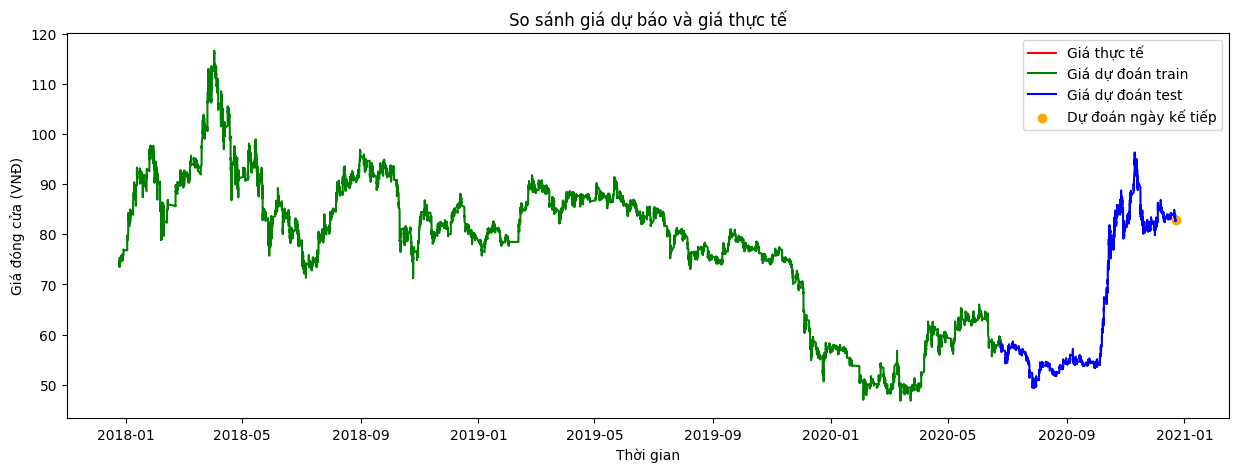

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Giá dự báo')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Date/Time': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

# Biến động giá cổ phiếu = Giá cổ phiếu N phút sau - Giá cổ phiếu hiện tại
stock_price_fluctuations = y_next_predict[0][0] - actual_closing_price
print("Biến động giá cổ phiếu:", stock_price_fluctuations)

            Date/Time  Giá dự đoán  Giá ngày trước
0 2020-12-23 14:46:00    82.815414            82.8
Biến động giá cổ phiếu: 0.015414428710940342
